This notebook will be used for Pupil's image captionin. Created by Kabir Guron.

## **Imports**

In [1]:
# Get the imports

import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset # Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

from PIL import Image

from pprint import pprint # Pretty printing
import json
import os



In [2]:
# Set seed

import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# set_seed(25) # https://www.youtube.com/watch?v=nX6N2tgLmaQ

## **Upload dataset**

In [3]:
import kagglehub
dataset_path = kagglehub.dataset_download("awsaf49/coco-2017-dataset")

Using Colab cache for faster access to the 'coco-2017-dataset' dataset.


In [4]:
dataset_path = os.path.join(dataset_path, "coco2017")

train_captions_path = os.path.join(dataset_path, "annotations/captions_train2017.json")
train_images_path = os.path.join(dataset_path, "train2017")

## **Create a dataloader**

In [5]:
from torch.utils.data.dataloader import DataLoader
# https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html

class DatasetCOCO2017(Dataset):

    def __init__(self, captions_path_json, images_path, img_transform=None, tokenizer=None, max_len_transformer=64):
        self.captions_path_json = captions_path_json
        self.images_path = images_path
        self.img_transform = img_transform
        self.tokenizer = tokenizer
        self.max_len_transformer = max_len_transformer

        # Load caption json file
        with open(self.captions_path_json, "r") as f:
            self.coco_json = json.load(f)

        # Create fast image lookup, O(n)
        #self.by_image_id = {}
        #for obj in self.coco_json:
        #    self.by_image_id[obj["image_id"]] = obj


    def __len__(self):
        return len(self.coco_json["annotations"])


    def __getitem__(self, idx):
        # For every caption there should be an image
        # Obtains the caption
        caption = self.coco_json["annotations"][idx]["caption"]

        # Image id and path
        img_id = self.coco_json["annotations"][idx]["image_id"]
        # Get the image that corresponds
        img_path = os.path.join(self.images_path, f"{str(img_id).zfill(12)}.jpg")

        # Get the image itself
        img = Image.open(img_path).convert("RGB")

        # Transform the image if necessary
        if self.img_transform:
            img = self.img_transform(img)

        return caption, img


## **Apply image transformations**

In [6]:
from torchvision import transforms
from torchvision.models import ViT_B_16_Weights

In [7]:
# ViT expects certain transformations such as 224x224 res,
weights = ViT_B_16_Weights.DEFAULT
base_transform = weights.transforms()

train_transform = transforms.Compose([
    transforms.ColorJitter(
        brightness=0.1,
        contrast=0.2,
        saturation=0.2
    ),
    transforms.RandomHorizontalFlip(0.2), # Some captions may rely on direction
    # transforms.RandomRotation(1), # Tilt probably not worth it, confuses model
    base_transform, # Used to normalize pixel values accordingly
])

## **Load the data**

In [10]:
#training_dataset = DatasetCOCO2017(
#    captions_path_json=train_captions_path,
#    images_path=train_images_path
#    )

training_dataset = DatasetCOCO2017(
    captions_path_json=train_captions_path,
    images_path=train_images_path,
    img_transform=train_transform
)

## **Visualize data**

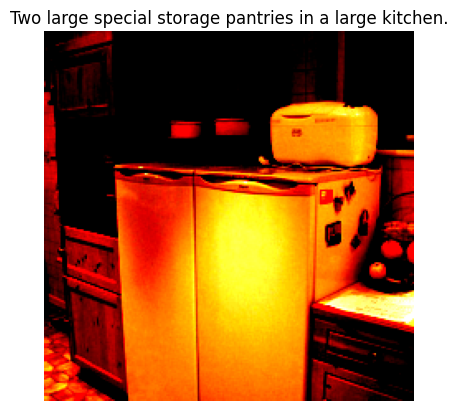

In [12]:

idx = int(random.random()*len(training_dataset))

caption_, image_ = training_dataset[idx]

image_vis = image_.permute(1, 2, 0)
# image_vis = image_
plt.imshow(image_vis)
plt.axis("off")
plt.title(caption_)
plt.show()

## **ViT Transformer**

In [15]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

weights = ViT_B_16_Weights.DEFAULT
vit_model = vit_b_16(weights=weights) # Upload default pretrained weights

In [16]:
# Freeze all layers

for param in vit_model.parameters():
    param.requires_grad = False # Layer will not be updated in backpropagation

# Remove class predictor => encoder-only
vit_model.heads = nn.Identity()

# x = torch.randn(2, 3, 224, 224)
# y = vit_model(x)
# print(y.shape)  # [2, 768]

In [ ]:

with open(path + "/coco2017/annotations/captions_train2017.json", "r") as f:
    coco = json.load(f)

print(coco.keys())


dict_keys(['info', 'licenses', 'images', 'annotations'])


In [ ]:



pprint(coco["images"][0])
pprint(coco["annotations"][1])


print(len(coco["images"]))
print(len(coco["annotations"]))
print(coco["annotations"][4]["caption"])



{'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg',
 'date_captured': '2013-11-14 11:18:45',
 'file_name': '000000391895.jpg',
 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg',
 'height': 360,
 'id': 391895,
 'license': 3,
 'width': 640}
{'caption': 'A room with blue walls and a white sink and door.',
 'id': 49,
 'image_id': 322141}
118287
591753
There is a GOL plane taking off in a partly cloudy sky.
